# Imports


In [20]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import math

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [51]:
df = pd.read_csv('../processeddata/SP500_prices.csv')
df.set_index(['Date'],inplace=True)
df = df[['Close']]

# Days to Forecasr
forecast_out = 1

df['Prediction'] = df['Close'].shift(-forecast_out)
df.dropna(inplace=True)

# Multivariate Linear Regression

linear model coeff (w): [281.2523128]
linear model intercept (b): 2061.252
R-squared score (training): 0.992
R-squared score (test): 0.994
RMSE: 13.636


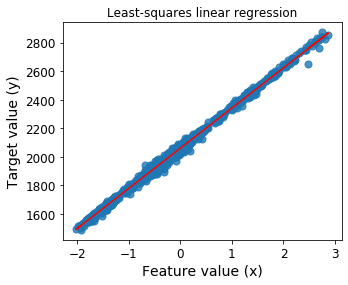

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = np.array(df.drop(['Prediction'], 1))

X = preprocessing.scale(X)
X = X[:-forecast_out]


Y = np.array(df['Prediction'])
Y = Y[:-forecast_out]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False)

linreg = LinearRegression().fit(X_train, y_train)

from sklearn import metrics

print('linear model coeff (w): {}'.format(linreg.coef_))

print('linear model intercept (b): {:.3f}'.format(linreg.intercept_))

print('R-squared score (training): {:.3f}'.format(linreg.score(X_train, y_train)))

print('R-squared score (test): {:.3f}'.format(linreg.score(X_test, y_test)))

# make predictions on the testing set
y_pred = linreg.predict(X_test)

print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

plt.figure(figsize=(5,4))
plt.scatter(X, Y, marker= 'o', s=50, alpha=0.8)
plt.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

# Ridge Regression

In [53]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Finding best regularization parameter\n")
for this_alpha in [0, 10, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

# Using 0 becaue best optimization
linridge = Ridge(alpha=0.0).fit(X_train_scaled, y_train)


print('SP500 dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Finding best regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 1, r-squared training: 0.99, r-squared test: 0.99

Alpha = 10.00
num abs(coeff) > 1.0: 1, r-squared training: 0.97, r-squared test: 0.81

Alpha = 50.00
num abs(coeff) > 1.0: 1, r-squared training: 0.78, r-squared test: -0.74

Alpha = 100.00
num abs(coeff) > 1.0: 1, r-squared training: 0.59, r-squared test: -2.23

Alpha = 1000.00
num abs(coeff) > 1.0: 1, r-squared training: 0.11, r-squared test: -6.14

SP500 dataset
ridge regression linear model intercept: 1491.0912813272093
ridge regression linear model coeff:
[683.20253723]
R-squared score (training): 0.992
R-squared score (test): 0.994
Number of non-zero features: 1


# Lasso Regression

In [54]:
from sklearn.linear_model import Lasso

print('Finding best regularization parameter\n')
for alpha in [0.5, 1, 3, 5, 10, 50]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    
    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

    
    
linlasso = Lasso(alpha=0.5, max_iter = 10000).fit(X_train_scaled, y_train)

print('Stock dataset')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))
        
        

Finding best regularization parameter

Alpha = 0.50
Features kept: 1, r-squared training: 0.99, r-squared test: 0.99

Alpha = 1.00
Features kept: 1, r-squared training: 0.99, r-squared test: 0.99

Alpha = 3.00
Features kept: 1, r-squared training: 0.99, r-squared test: 0.95

Alpha = 5.00
Features kept: 1, r-squared training: 0.98, r-squared test: 0.89

Alpha = 10.00
Features kept: 1, r-squared training: 0.94, r-squared test: 0.58

Alpha = 50.00
Features kept: 0, r-squared training: 0.00, r-squared test: -6.98

Stock dataset
lasso regression linear model intercept: 1495.8278694842847
lasso regression linear model coeff:
[675.62059441]
Non-zero features: 1
R-squared score (training): 0.992
R-squared score (test): 0.992

Features with non-zero weight (sorted by absolute magnitude):
	[-1.92089138], 675.621
